# Evaluating Llama 2 70b Chat - binary

In [1]:
import random
import sys
sys.path.append('..')
import pandas as pd
from src.api import API
from src.dataloader import DataLoader
from src.prompter import prompter_factory
from src.scorer import scorer_factory
from src.scorer import compare_models_bootstrap
from dotenv import load_dotenv
load_dotenv()
import os

In [2]:
TOGETHER_API_KEY = os.getenv("API_KEY")
BASE_URL = "https://api.together.xyz"

In [3]:
api = API(api_key=TOGETHER_API_KEY, base_url=BASE_URL)
client = api.get_openai()

In [4]:
dataloader = DataLoader(path="../data/")
data = dataloader.get_standardized_dataframe(context_col="Text Data",
                                             target_binary_col="symptom_status_gs",
                                             target_multilabel_col="symptom_detail_gs",
                                             keep_other_cols=True)

In [5]:
Llama2_70B_Chat = prompter_factory(prompter_type="binary",
                                   client=client,
                                   model="meta-llama/Llama-2-70b-chat-hf")

In [33]:
prompt = "You are a helpful model diagnosing diseases based on Doctor - Patient conversations. \
            Given a conversation, you should determine whether the patient has symptoms or not. \
            Some symptoms will be mentioned but will not apply to the patient. It is important \
            that you only consider symptoms that are experienced by the patient. \
            An example of a patient mentioning a symptom that does not apply to them is: \
            'P: My daughter is having fevers and barely sleeps'. Your answer should be \
            'No'. It is also important that you only consider explicit mentions of symptoms. \
            An example of a patient not explicitly mentioning a symptom is: \
            'D: You need to get an MRI as soon as possible. P: OK. D: Alright.' \
            Your answer should be: 'No'. \
            You should refrain from answering yes if you are not certain. If you are not \
            certain, your answer should be: 'No'. \
            Here is the list of possible symptoms: \
            ['anxiety', 'concentration problems', 'constipation', 'cough', \
                    'diarrhea', 'fatigue', 'fever', 'headache', 'nausea', \
                    'numbness and tingling', 'pain', 'poor appetite', 'rash', \
                    'shortness of breath', 'trouble drinking fluids', 'vomiting', 'other'] \
            If you detect any of these symptoms, your answer should be 'Yes'. Otherwise, \
            your answer should be 'No'. \
            Are any medical symptoms mentioned in the transcript?"

In [34]:
results_llama2_70B_chat = Llama2_70B_Chat.generate(df=data, prompt=prompt)

binary task using: meta-llama/Llama-2-70b-chat-hf - Total tokens: 354,973: 100%|██████████| 550/550 [00:21<00:00, 25.43it/s]


## Model evaluation

Bootstrapping Llama2_70B_Chat: 100%|██████████| 1000/1000 [00:03<00:00, 250.76it/s]


accuracy: 0.8483 (0.819-0.8775 95% CI)
precision: 0.832 (0.7991-0.8652 95% CI)
recall: 0.9791 (0.9634-0.9921 95% CI)
f1: 0.8995 (0.8782-0.9206 95% CI)
Unstructured output ratio: 0.0056 (0.0-0.0127 95% CI)


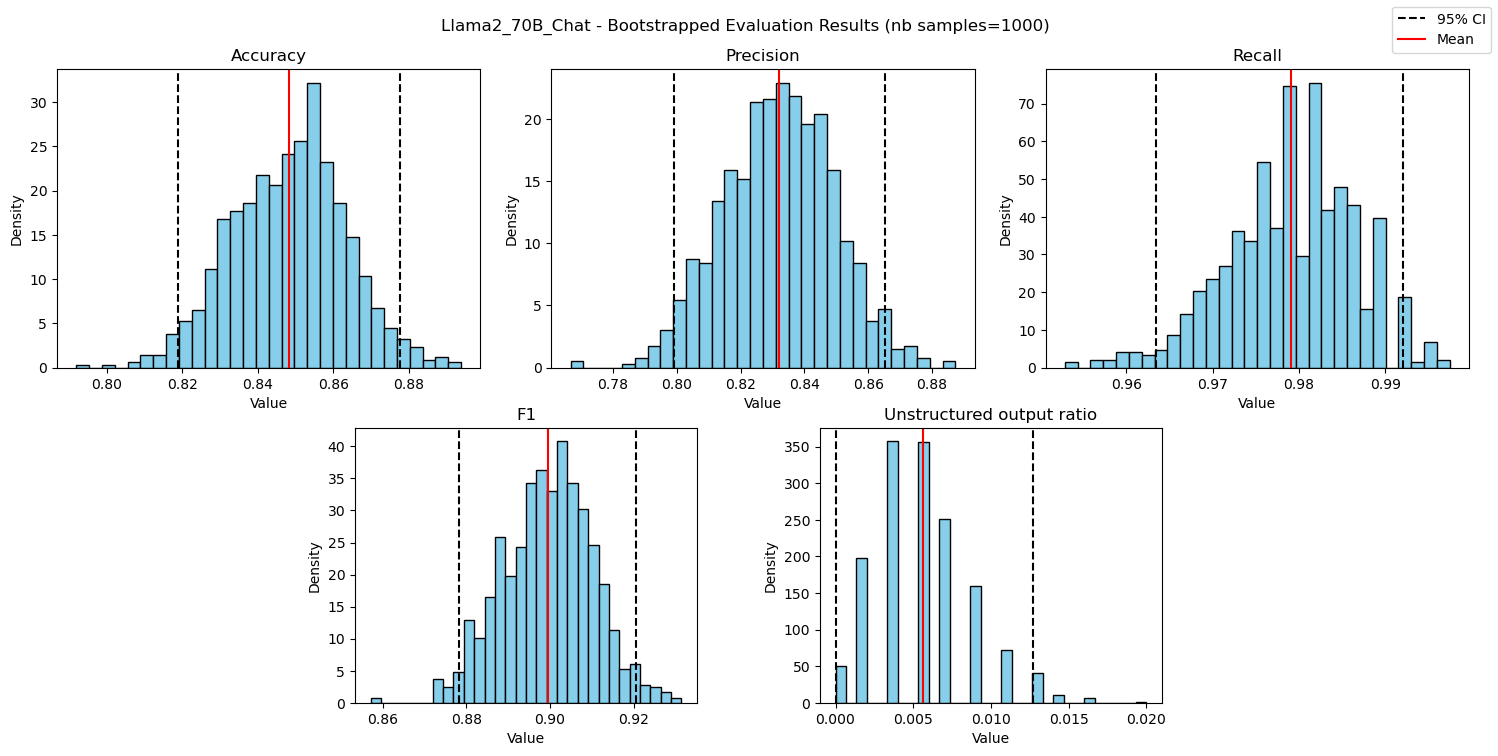

In [35]:
scorer_llama2_70B_chat = scorer_factory(scorer_type="binary", data=data, results=results_llama2_70B_chat, model_name="Llama2_70B_Chat")
scorer_llama2_70B_chat.display_bootstrap_results(sample_size=len(data), output_type="both", n_samples=1000)

In [9]:
Mistral7B = prompter_factory(prompter_type="binary",
                             client=client,
                             model="mistralai/Mistral-7B-Instruct-v0.1")
results_mistral7b = Mistral7B.generate(df=data, prompt=prompt)
scorer_mistral7b = scorer_factory(scorer_type="binary", data=data, results=results_mistral7b, model_name="Mistral 7B")

Mixtral8x7B = prompter_factory(prompter_type="binary",
                               client=client,
                               model="mistralai/Mixtral-8x7B-Instruct-v0.1")
results_mixtral8x7b = Mixtral8x7B.generate(df=data, prompt=prompt)
scorer_mixtral8x7b = scorer_factory(scorer_type="binary", data=data, results=results_mixtral8x7b, model_name="Mixtral 8x7B")

dict_scorers = {"Mistral7B": scorer_mistral7b, "Mixtral8x7B": scorer_mixtral8x7b, "Llama2 70B Chat": scorer_llama2_70B_chat}
compare_models_bootstrap(dict_scorers=dict_scorers, sample_size=len(data), n_samples=1000)

binary task using: mistralai/Mistral-7B-Instruct-v0.1 - Total tokens: 105,570:  33%|███▎      | 179/550 [00:22<00:38,  9.64it/s]

## Error Interrogation

In [28]:
df_llama2_70B_chat_error = scorer_llama2_70B_chat.get_error_dataframe()

In [29]:
df_llama2_70B_chat_error['Pred status'].value_counts(dropna=False)

Pred status
NaN      173
True      26
False      6
Name: count, dtype: int64

In [32]:
df_llama2_70B_chat_error[df_llama2_70B_chat_error["Pred status"].isnull()]["Pred output"]

2        Based on the conversation between the doctor...
5        Based on the conversation, the patient has n...
6        Based on the conversation provided, the pati...
19       Based on the conversation between the doctor...
27       Based on the conversation between the doctor...
                             ...                        
532      Based on the conversation between the doctor...
538      Based on the conversation between the doctor...
539      Based on the conversation between the doctor...
540      Based on the conversation between the doctor...
541      Based on the conversation between the doctor...
Name: Pred output, Length: 173, dtype: object

In [12]:
selected_columns = df_llama2_70B_chat_error.columns[:df_llama2_70B_chat_error.columns.get_loc("Target binary")+2].to_list() + ["Pred status"] + ["Pred output"]
df_llama2_70B_chat_error[selected_columns].describe()

,Context,Symptom Status_bd,Detailed Choices_bd,Source_x,Symptom Status_CVD,Detailed Choices_CVD,Source_y,Differences,Adjudication Decision,Pres_Abs_Diffs,Target binary,symptom_detail_gs,Pred status,Pred output
count,109,45,12,109,109,33,109,15,15,9,109,29,69,109
unique,109,2,11,47,2,19,47,8,6,2,2,18,2,109
top,"P: Uhm, so my younger sister had a sore throat...",Negative,Other,RES0168.txt,Negative,Other,RES0168.txt,None;Other,NONE,Negative;Positive,False,other,True,"Based on the conversation provided, the pati..."
freq,1,34,2,5,76,12,5,6,8,6,80,7,60,1


In [13]:
unique_values = df_llama2_70B_chat_error["Symptom Status_bd"].unique()
print(unique_values)


['Positive' 'Negative' nan]


In [17]:
df_llama2_70B_chat_error.loc[:, "Concatenated"] = df_llama2_70B_chat_error.apply(
    lambda row: f"index: {row.name}\n\nContext: {row['Context']}\n\n\nModel Output: {row['Pred status']}",
    axis=1
)
# Converting to a list makes for an easier way to print the results
concatenated_list = df_llama2_70B_chat_error["Concatenated"].tolist()

In [24]:
random.shuffle(concatenated_list)
print(concatenated_list[0])

index: 187

Context: P: Yeah, we've been wearing masks and and there are cleaning protocols and distancing protocols as well. Trying to keep everybody safe.

D: OK, and since you've had these symptoms, have you gone into work at all?

P: No, no, I've actually. I've been off for the the last couple of days.

D: OK. 

P: Yeah I've just been been doing what I can from home, 

D: OK. And what's your home situation like? Who do you live with?

P: Yeah, so I live with my I live with my wife and we live in a townhouse just right in the city here.

D: OK, and has she been displaying any symptoms at all?

P: Uh no she hasn't. She's been been feeling good.

D: OK, that's good, and currently do you smoke?


Model Output: True


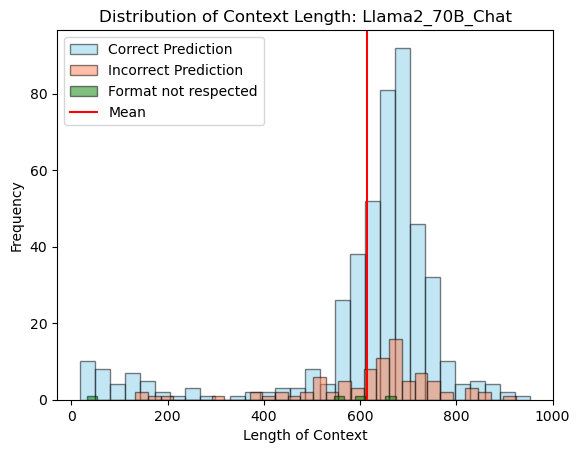

In [ ]:
scorer_llama2_70B_chat.display_length_distribution()